# Data Challenge 1: David Riser
Our first data challenge asks us to predict employee turnover, decide the main factors which drive it, and offer advice about how to improve employee retention.

## Table of Contents:
* 1. Problem Statement and Objectives
    * 1.1 Basic problem statement 
    * 1.2 Metrics for success 
* 2. Loading and Cleaning
    * 2.1 Loading the data with Pandas
    * 2.2 Outliers and NaN values 
* 3. Feature Engineering
    * 3.1 Basic compensation features
    * 3.2 Employee lifetime features
* 4. Visual Exploration
    * 4.1 Correlation between variables
* 5. Modeling
    * 5.1 Scaling and transforming
    * 5.2 Logistic regression model 
    * 5.3 Performance analysis 
* 6. Interpretation of Model
    * 6.1 Attrition predictors 
    * 6.2 Actionable steps to reduce attration

## 1. Problem Statement and Objectives

### 1.1 Basic Problem Statement
Employee attrition (an employee quits) is expensive for the company who loses the employee, often costing them over $100K.  For this data challenge we've been asked to predict which employees are at risk of quitting, and provide some actionable insights on how to improve the situation.  We've also been asked which factors (features) are the best predictors of employee attrition.

### Data 
Several companies have provided HR data on employee attrition (24,702 employee records), we will explore the structure of this data in section 2.1.

### Objectives 
* Ensure the data are valid.  Before building models and making predictions and creating knowledge, i'll do my best to verify the integrity of the data and data collection.
* Provide a model that predicts employee attrition.
* Offer suggestions on actionable ways to improve employee attrition rates, validate these suggestions if possible.

### 1.2 Metrics for Success
The problem statement implies that losing employees is very costly.  Depending on what our suggestion is for retaining employees, it's likely less costly to the company to offer incentives to at risk employees than it is to lose them.  For this reason, I believe it is important to not miss true positives and that I can tolerate some level of false positives.  For this reason, i'll be optimizing the recall of the model.  We'll also dive a little deeper into more informative metrics provided that there is time.

In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns 

%matplotlib inline

## 2. Loading and Cleaning
In this section the data is loaded into memory and we aim to clean the data for our machine learning model.  Additionally, we seek to decide if the data is reasonably representative of the ground truth and will actually build a useful model.

### 2.1 Loading with Pandas

In [2]:
data = pd.read_csv('./employee_retention_data.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
employee_id    24702 non-null float64
company_id     24702 non-null int64
dept           24702 non-null object
seniority      24702 non-null int64
salary         24702 non-null float64
join_date      24702 non-null object
quit_date      13510 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 1.3+ MB


We can see the basic structure of the data from a basic computer perspective here, the dates are stored as objects (strings) and will need to be converted to numerical representations.  I chose to convert each date into a year, month, day format using three columns.

### 2.2 Outliers and NaN Values
In this section, I want to inspect the dataset and check for values which are obviously outliers and then make a decision on what to do with them.  Additionally, i'll handle NaN values in this section. 

In [4]:
data.describe()

,employee_id,company_id,seniority,salary
count,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478
std,288909.026101,2.700011,8.089520,76058.184573
min,36.000000,1.000000,1.000000,17000.000000
25%,250133.750000,1.000000,7.000000,79000.000000
50%,500793.000000,2.000000,14.000000,123000.000000
75%,753137.250000,5.000000,21.000000,187000.000000
max,999969.000000,12.000000,99.000000,408000.000000


Here we can see that something doesn't make sense.  The seniority variable which describes the number of years of experience of an employee is actually 99 for some employees.  Let's see how many.

In [5]:
data[data['seniority'] > 50]

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
24700,97289.0,10,engineer,98,266000.0,2011-12-13,2015-01-09
24701,604052.0,1,marketing,99,185000.0,2011-07-26,2013-12-06


Since these represent such a small fraction of the entire sample, I am going to remove them from this analysis.  The employee from company 10 may be important because of the relatively small size of company 10.  If that turns out to be the case, we could try guessing the seniority of these employees by looking at their department and salary.  For now let's continue without these two employees.  Let's look for missing values now.

In [6]:
data.isna().sum()

employee_id        0
company_id         0
dept               0
seniority          0
salary             0
join_date          0
quit_date      11192
dtype: int64

Here it's clear that the dataset is somewhat clean already.  The missing values in `quit_date` correspond to employees which have not quit and are still employed as of 12/31/2015.  In the cleaning phase, we will use that to create a binary target variable called `churn_status` to represent the employees status.  Let's define our cleaning function and proceed to clean the dataset.

In [7]:
def process_date(date_string):
    ''' Tokenize dates into arrays of integers. 
    
        Arguments: 
        date_string - String containing a date in the 
        format year/month/day.  
        
        Ouptut:
        If the input is null, the 
        function returns an array of zeros.  Otherwise
        the array is returned with [year, month, day].
    '''
    if type(date_string) == str:
        tokens = date_string.split('-')
        tokens = [int(t) for t in tokens]
        
        if len(tokens) != 3:
            return np.array([0, 0, 0])
        else:
            return np.array(tokens)
        
    return np.array(([0, 0, 0]))

def get_year(date_string):
    return process_date(date_string)[0]

def get_month(date_string):
    return process_date(date_string)[1]

def get_day(date_string):
    return process_date(date_string)[2]

def clean_dataset(data):
    ''' Clean employee dataset of NaN values and add target. 
    
        This function uses the insights gained above to clean 
        the employee/company dataset.
        
        Arguments: 
        data - The input dataframe which contains the employee data.
        
        Output: 
        data - The modified dataframe is returned. 
    '''
    
    data = data[data['seniority'] < 90]
    
    # Add target as float 0/1.
    data['churn_status'] = data['quit_date'].notna().round()
    
    # Decompose join date string into 3 integers. 
    data['join_year'] = data['join_date'].apply(get_year)    
    data['join_month'] = data['join_date'].apply(get_month)
    data['join_day'] = data['join_date'].apply(get_day)

    # Decompose quit date string into 3 integers.     
    data['quit_year'] = data['quit_date'].apply(get_year)    
    data['quit_month'] = data['quit_date'].apply(get_month)
    data['quit_day'] = data['quit_date'].apply(get_day)
    
    # Drop useless columns 
    data.drop(columns = ['join_date', 'quit_date'], inplace = True)
    
    return data 

In [8]:
data = clean_dataset(data)

/Users/davidriser/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/davidriser/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/davidriser/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [9]:
data.head()

,employee_id,company_id,dept,seniority,salary,churn_status,join_year,join_month,join_day,quit_year,quit_month,quit_day
0,13021.0,7,customer_service,28,89000.0,1.0,2014,3,24,2015,10,30
1,825355.0,7,marketing,20,183000.0,1.0,2013,4,29,2014,4,4
2,927315.0,4,marketing,14,101000.0,0.0,2014,10,13,0,0,0
3,662910.0,7,customer_service,20,115000.0,1.0,2012,5,14,2013,6,7
4,256971.0,2,data_science,23,276000.0,1.0,2011,10,17,2014,8,22


Before moving to feature engineering, let's quickly see if the classes are balanced.

In [10]:
data['churn_status'].value_counts()

1.0    13508
0.0    11192
Name: churn_status, dtype: int64

Not too bad.

## 3. Feature Engineering 
Let's use all of our creativity to add some features from the domain that might be useful.

In [11]:
def feature_engineer(data):
    
    # Total number of days worked at the company 
    # for those who quit (I will fix the others below).
    data['days_worked'] = 365 * (data['quit_year'] - data['join_year']) + \
        365.25 / 12.0 * (data['quit_month'] - data['join_month']) + \
        (data['quit_day'] - data['join_day'])
    
    # Add some days worked for peolpe who didn't quit. 
    indexer = data['days_worked'] < 0

    data['days_worked'].loc[indexer] = 365 * (2015 - data['join_year'].loc[indexer]) + \
        365.25 / 12.0 * (12 - data['join_month'].loc[indexer]) + \
        (31 - data['join_day'].loc[indexer])
    
    # By plotting salary and seniority one can see that there are clearly
    # three steps for every company.
    data['career_level'] = np.digitize(data['seniority'], np.array([0, 5, 15, 99]))
    
    # Encode the departments into columns
    department = data['dept']
    data = pd.get_dummies(data, columns = ['dept'], prefix = 'dept')
    data['dept'] = department
    
    # Compare the individual employee to the average in their division 
    # by computing z-score 
    data['average_salary_in_division'] = data.groupby(['company_id', 'dept', 'career_level']).transform('mean')['salary']
    data['std_salary_in_division'] = data.groupby(['company_id', 'dept', 'career_level']).transform('std')['salary']
    data['internal_salary_zscore'] = (data['salary'] - data['average_salary_in_division']) / data['std_salary_in_division']
    data['internal_salary_zscore'].fillna(0, inplace = True)
    data.drop(columns = ['average_salary_in_division', 'std_salary_in_division'], inplace = True)

    # Compare the individual employee to the average in their division 
    # by computing z-score 
    data['average_salary_in_profession'] = data.groupby(['dept', 'career_level']).transform('mean')['salary']
    data['std_salary_in_profession'] = data.groupby(['dept', 'career_level']).transform('std')['salary']
    data['profession_salary_zscore'] = (data['salary'] - data['average_salary_in_profession']) / data['std_salary_in_profession']
    data['profession_salary_zscore'].fillna(0, inplace = True)
    data.drop(columns = ['average_salary_in_profession', 'std_salary_in_profession'], inplace = True)
    
    # Figure out how long the person worked before coming to this company 
    # Need to insert zeros if people haven't worked before coming here.
    # This variable has problems check it out.
    data['previous_days_worked'] = 365.25 * data['seniority'] - data['days_worked']
    data['previous_days_worked'] = data['previous_days_worked'].apply(lambda x: 0.0 if x < 0 else x)
    
    # How much of their careers have they worked here? 
    data['career_fraction_in_company'] = data['days_worked'] / (data['days_worked'] + data['previous_days_worked'])
    
    # How much of the department years of experience 
    # does each person have? 
    data['dept_experience_fraction'] = data['seniority'] / data.groupby(['company_id', 'dept']).transform('sum')['seniority']
    data['dept_experience_fraction'].fillna(0, inplace = True)
    
    # How does their experience compare to the top dog?
    data['dept_experience_disparity'] = data.groupby(['company_id', 'dept']).transform('max')['seniority'] - data['seniority']
    data['dept_experience_disparity'].fillna(data['seniority'].max(), inplace = True)
    
    # Compare the individual employee to the average in their division 
    # by computing z-score of seniority
    data['average_seniority_in_profession'] = data.groupby(['dept', 'career_level']).transform('mean')['seniority']
    data['std_seniority_in_profession'] = data.groupby(['dept', 'career_level']).transform('std')['seniority']
    data['profession_seniority_zscore'] = (data['seniority'] - data['average_seniority_in_profession']) / data['std_seniority_in_profession']
    data['profession_seniority_zscore'].fillna(0, inplace = True)
    data.drop(columns = ['average_seniority_in_profession', 'std_seniority_in_profession'], inplace = True)    
    data['profession_seniority_zscore'].fillna(0, inplace = True)
    
    # Compare the individual employee to the average in their division 
    # by computing z-score of seniority
    #data['average_seniority_in_division'] = data.groupby(['company_id' ,'dept', 'career_level']).transform('mean')['seniority']
    #data['std_seniority_in_division'] = data.groupby(['company_id', 'dept', 'career_level']).transform('std')['seniority']
    #data['division_seniority_zscore'] = (data['salary'] - data['average_seniority_in_division']) / data['std_seniority_in_division']
    #data['division_seniority_zscore'].fillna(0, inplace = True)
    #data.drop(columns = ['average_seniority_in_division', 'std_seniority_in_division'], inplace = True)  
    #data['division_seniority_zscore'].fillna(0, inplace = True)
    
    # Has the employee taken a step up during their 
    # time in the company.  This happens from 4-5 and
    # from 14-15 according to our visual analysis below.
    current_experience = data['seniority'].values
    previous_experience = data['previous_days_worked'].values / 365.25
    data['step_up_1'] = (current_experience >= 5) & (previous_experience < 5)
    data['step_up_2'] = (current_experience >= 15) & (previous_experience < 14)
    data['step_up_1'] = data['step_up_1'].astype(int)
    data['step_up_2'] = data['step_up_2'].astype(int)

    return data

In [12]:
data = feature_engineer(data)
data.head(12)

/Users/davidriser/anaconda3/envs/insight/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,employee_id,company_id,seniority,salary,churn_status,join_year,join_month,join_day,quit_year,quit_month,...,dept,internal_salary_zscore,profession_salary_zscore,previous_days_worked,career_fraction_in_company,dept_experience_fraction,dept_experience_disparity,profession_seniority_zscore,step_up_1,step_up_2
0,13021.0,7,28,89000.0,1.0,2014,3,24,2015,10,...,customer_service,-0.761004,-1.200686,9642.9375,0.057110,0.004165,1,1.550613,0,0
1,825355.0,7,20,183000.0,1.0,2013,4,29,2014,4,...,marketing,1.330631,0.105023,6965.0000,0.046543,0.010325,9,-0.319690,0,0
2,927315.0,4,14,101000.0,0.0,2014,10,13,0,0,...,marketing,-0.347946,-0.945573,4669.6250,0.086805,0.003837,15,1.565323,0,0
3,662910.0,7,20,115000.0,1.0,2012,5,14,2013,6,...,customer_service,1.976543,0.394777,6916.5625,0.053174,0.002975,9,-0.329178,0,0
4,256971.0,2,23,276000.0,1.0,2011,10,17,2014,8,...,data_science,-0.837331,0.101311,7361.6250,0.123694,0.002769,6,0.389992,0,0
5,509529.0,4,14,165000.0,1.0,2012,1,30,2013,8,...,data_science,0.408610,-0.391116,4535.4375,0.113046,0.003540,15,1.630788,0,0
6,88600.0,4,21,107000.0,0.0,2013,10,21,0,0,...,customer_service,1.183250,-0.096135,6869.3750,0.104413,0.001946,8,-0.094204,0,0
7,716309.0,2,4,30000.0,0.0,2014,3,5,0,0,...,customer_service,0.081826,0.704173,796.0625,0.455125,0.000180,25,1.367156,0,0
8,172999.0,9,7,160000.0,1.0,2012,12,10,2015,10,...,engineer,0.311569,-0.620292,1509.6250,0.409553,0.002677,22,-0.868630,1,0
9,504159.0,1,7,104000.0,0.0,2012,6,12,0,0,...,sales,-1.966423,-0.768153,1260.1250,0.507138,0.000456,22,-0.829365,1,0


## 4. Visual Exploration

I am going to set some style preferences before the plotstorm begins.

In [13]:
plt.rc('font', family = 'serif')
plt.rc('font', size = 18)

Text(0, 0.5, 'Seniority (Years)')

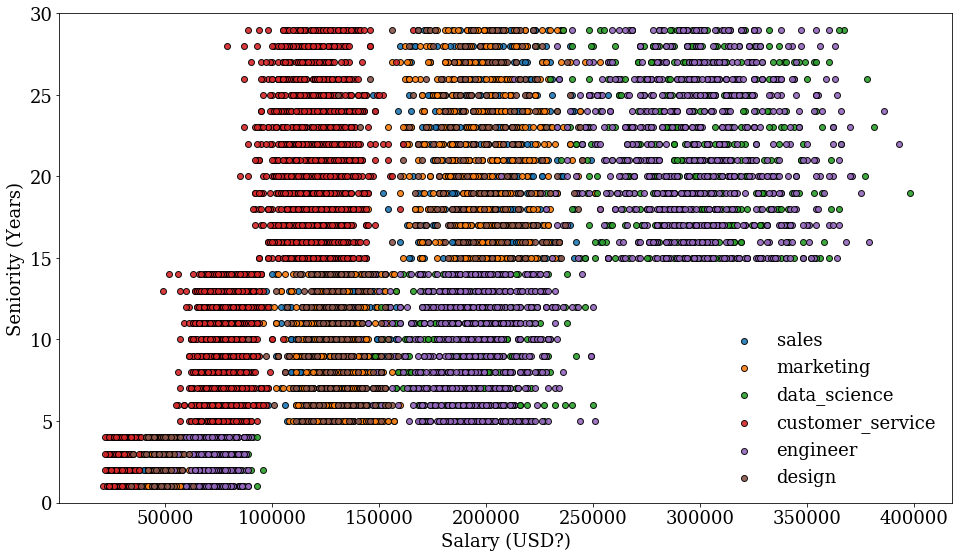

In [14]:
plt.figure(figsize = (16, 9))

company_data = data.query('company_id == 1')

for department in company_data['dept'].unique():
    plt.scatter(
        company_data.query('dept == "{}"'.format(department))['salary'],
        company_data.query('dept == "{}"'.format(department))['seniority'],
        edgecolor = 'k',
        alpha = 0.9,
        label = department
    );
    
plt.ylim([0, 30])
plt.legend(frameon = False)
plt.xlabel('Salary (USD?)')
plt.ylabel('Seniority (Years)')

Text(0, 0.5, 'Pay Step')

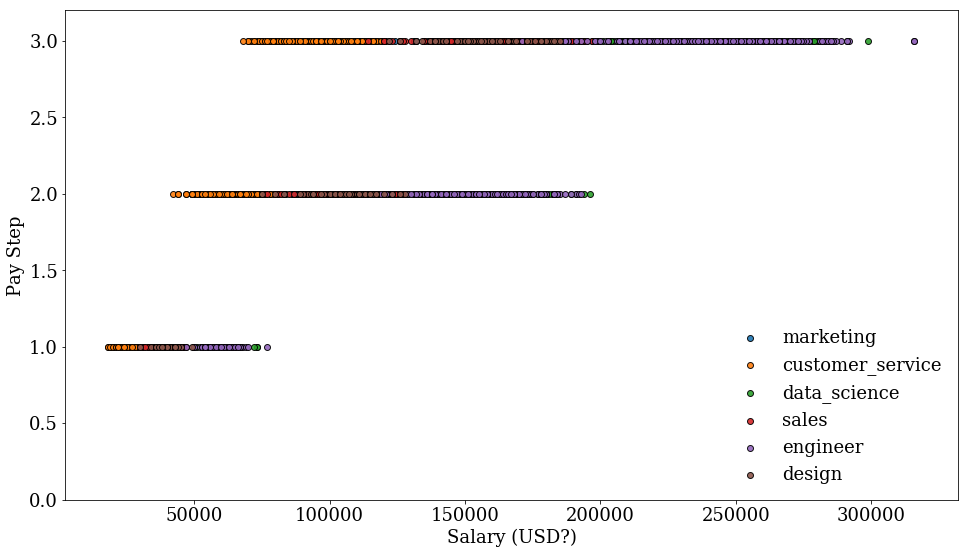

In [15]:
plt.figure(figsize = (16, 9))

company_data = data.query('company_id == 3')

for department in company_data['dept'].unique():
    plt.scatter(
        company_data.query('dept == "{}"'.format(department))['salary'],
        company_data.query('dept == "{}"'.format(department))['career_level'],
        edgecolor = 'k',
        alpha = 0.9,
        label = department
    );
    
plt.ylim([0, 3.2])
plt.legend(frameon = False)
plt.xlabel('Salary (USD?)')
plt.ylabel('Pay Step')

Text(0.5, 1.0, 'Marketing Salaries for Company 1')

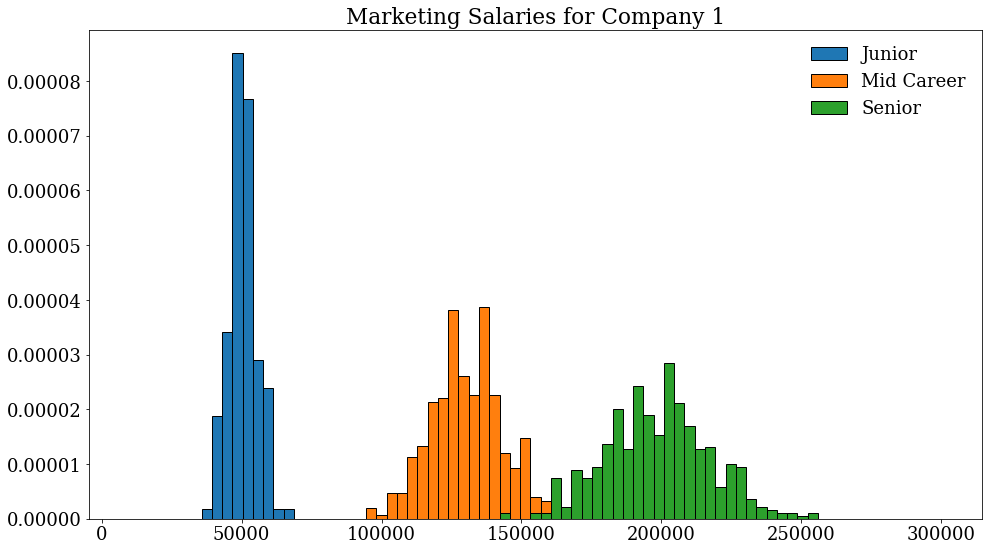

In [16]:
plt.figure(figsize = (16, 9))
plt.hist(
    data.query('company_id == 1 and dept_marketing == 1 and career_level == 1')['salary'],
    bins = np.linspace(10000, 300000, 80),
    edgecolor = 'k',
    density = True,
    label = 'Junior'
);
plt.hist(
    data.query('company_id == 1 and dept_marketing == 1 and career_level == 2')['salary'],
    bins = np.linspace(10000, 300000, 80),
    edgecolor = 'k',
    density = True,
    label = 'Mid Career'
);
plt.hist(
    data.query('company_id == 1 and dept_marketing == 1 and career_level == 3')['salary'],
    bins = np.linspace(10000, 300000, 80),
    edgecolor = 'k',
    density = True,
    label = 'Senior'
);
plt.legend(frameon = False)
plt.title('Marketing Salaries for Company 1')

This figure reveals something interesting.  Employees within company one with the same level of experience are not compensated the same.  Perhaps this information can be used as a predictor.  One could imagine using a z-score for each employee, reflecting how far away they are from the mean salary in their bracket.

<BarContainer object of 6 artists>

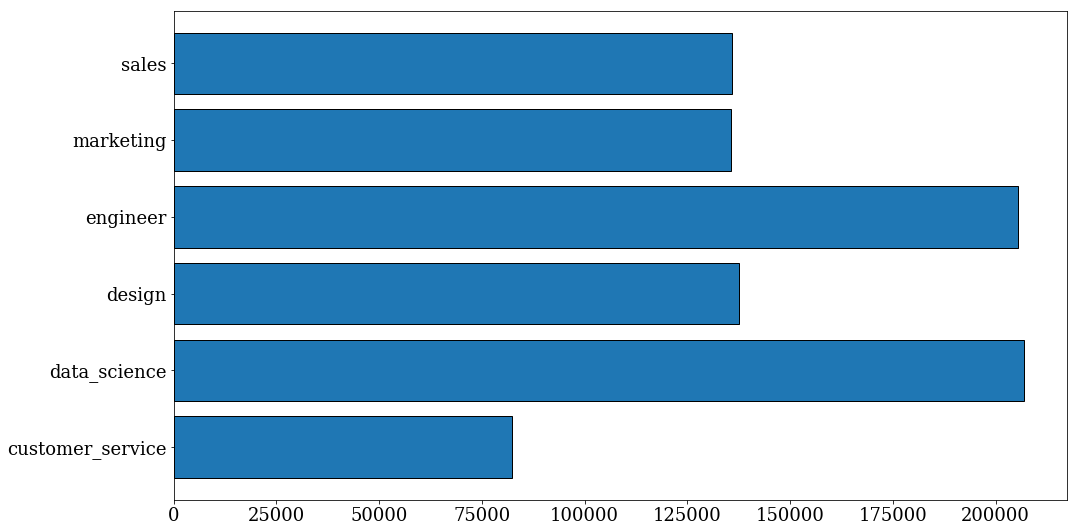

In [17]:
global_salary_by_department = data.groupby('dept').aggregate(
    {
        'salary' : np.mean
    }
)

plt.figure(figsize = (16, 9))
plt.barh(
    global_salary_by_department.index, 
    global_salary_by_department.values.reshape(len(global_salary_by_department)),
    edgecolor = 'k' 
)

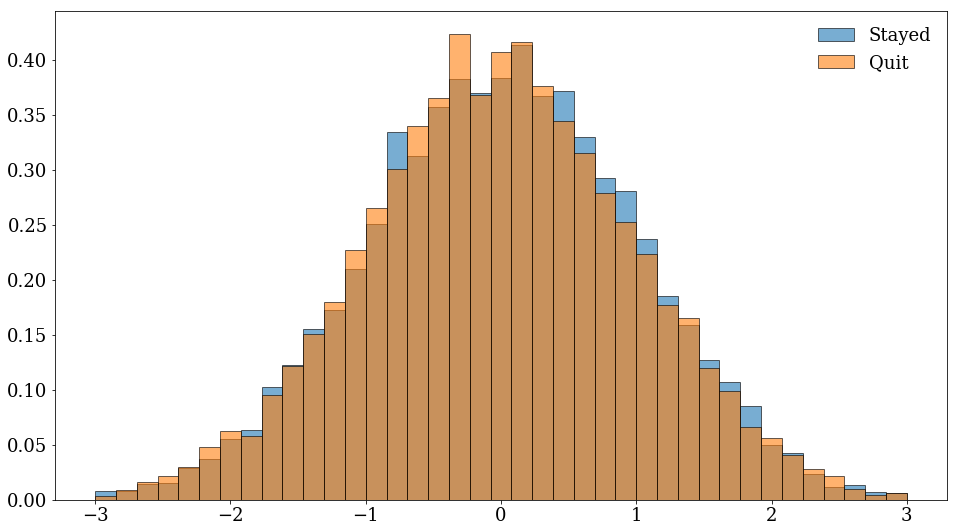

In [18]:
plt.figure(figsize = (16, 9))
plt.hist(
    data.query('churn_status < 0.5')['internal_salary_zscore'],
    bins = np.linspace(-3, 3, 40),
    edgecolor = 'k',
    alpha = 0.6,
    label = 'Stayed',
    density = True
);
plt.hist(
    data.query('churn_status > 0.5')['internal_salary_zscore'],
    bins = np.linspace(-3, 3, 40),
    edgecolor = 'k',
    alpha = 0.6,
    label = 'Quit',
    density = True
);
plt.legend(frameon = False)

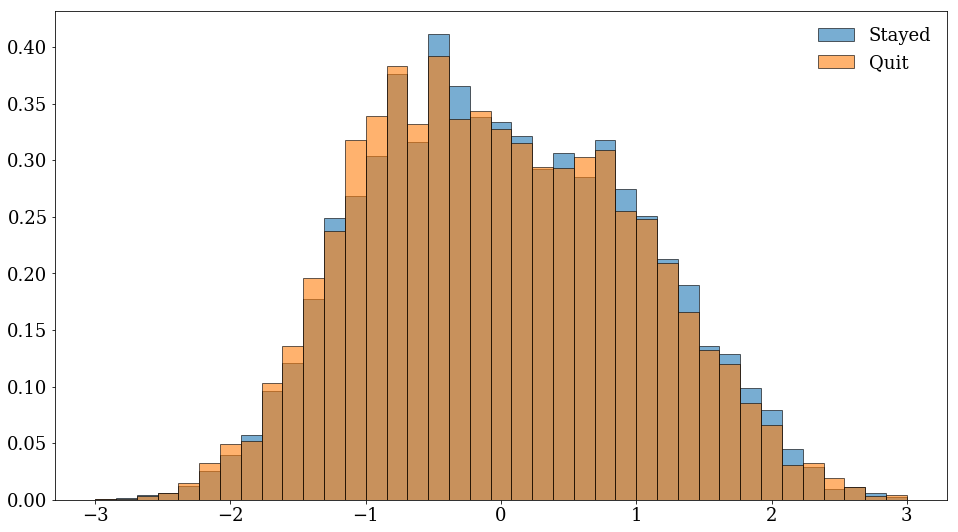

In [19]:
plt.figure(figsize = (16, 9))
plt.hist(
    data.query('churn_status < 0.5')['profession_salary_zscore'],
    bins = np.linspace(-3, 3, 40),
    edgecolor = 'k',
    alpha = 0.6,
    label = 'Stayed',
    density = True
);
plt.hist(
    data.query('churn_status > 0.5')['profession_salary_zscore'],
    bins = np.linspace(-3, 3, 40),
    edgecolor = 'k',
    alpha = 0.6,
    label = 'Quit',
    density = True
);
plt.legend(frameon = False)

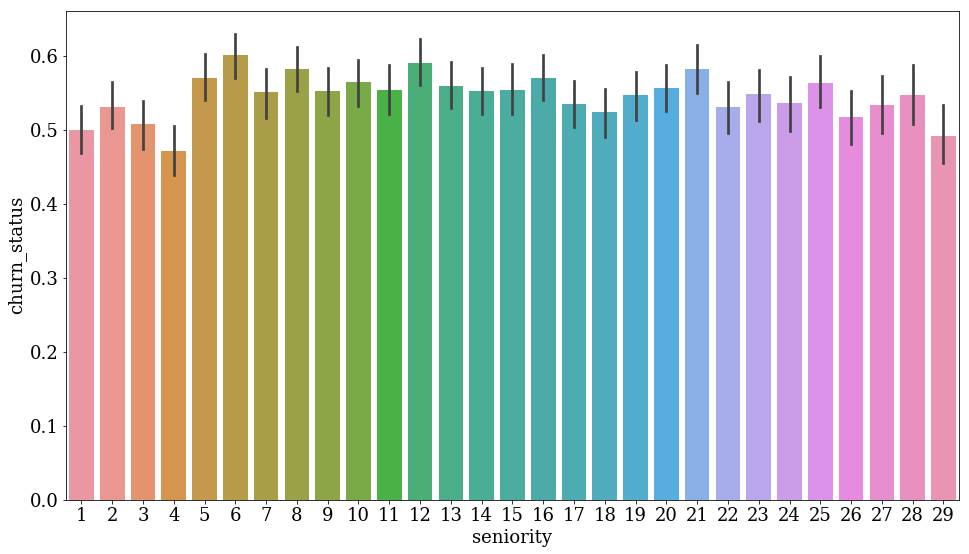

In [20]:
plt.figure(figsize = (16, 9))
sns.barplot(data['seniority'], data['churn_status'])

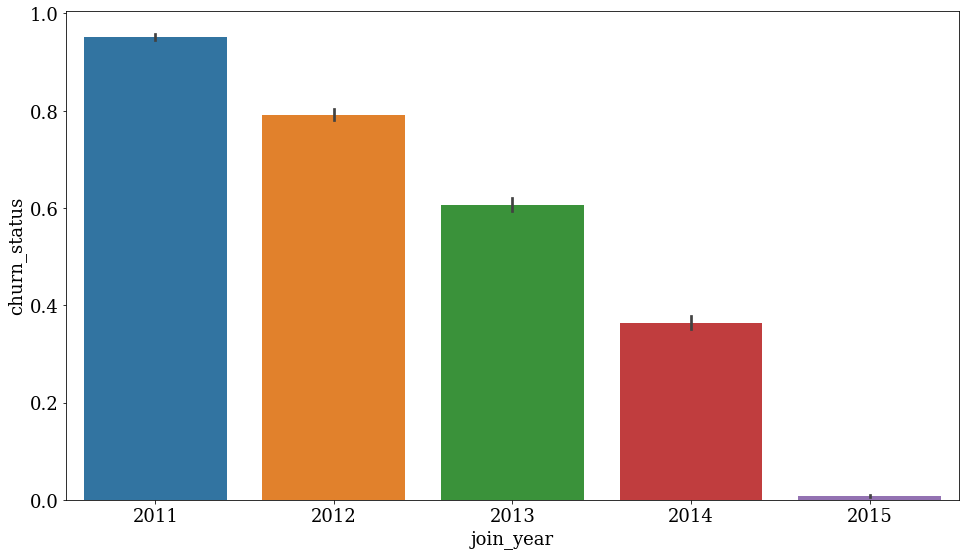

In [21]:
plt.figure(figsize = (16, 9))
sns.barplot(data['join_year'], data['churn_status'])

/Users/davidriser/anaconda3/envs/insight/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/davidriser/anaconda3/envs/insight/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


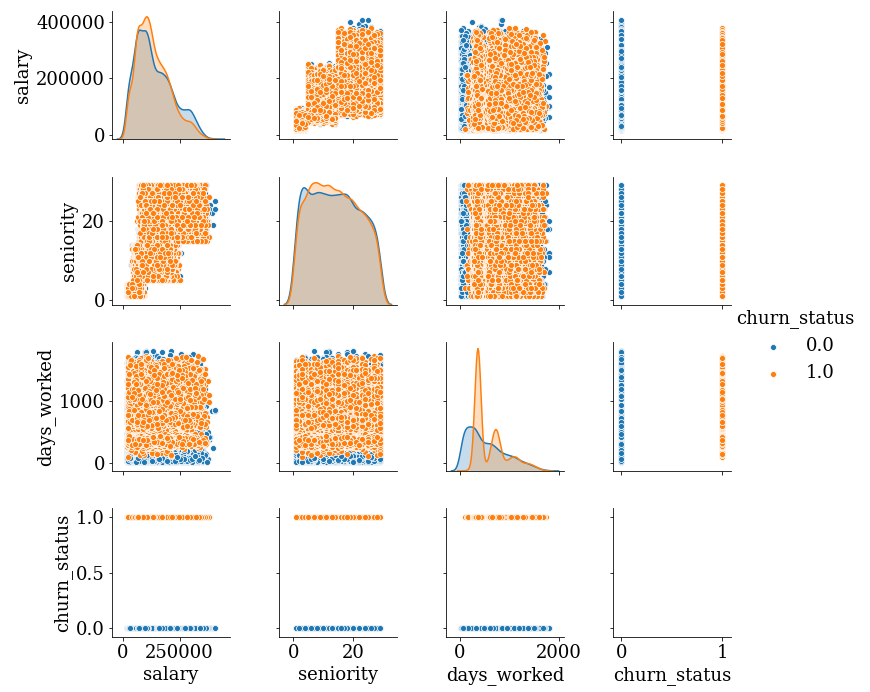

In [22]:
sns.pairplot(data[['salary', 'seniority', 'days_worked', 'churn_status']], hue = 'churn_status')

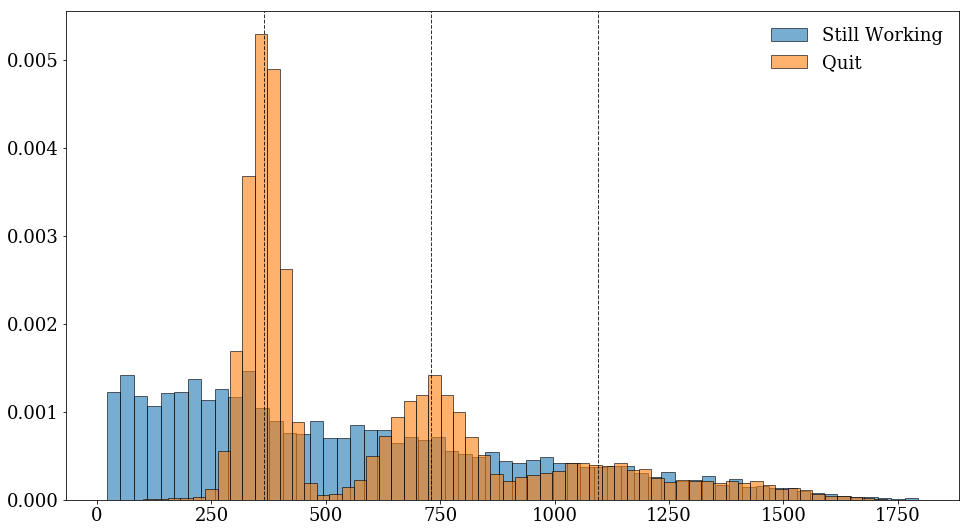

In [23]:
plt.figure(figsize = (16, 9))
plt.hist(
    data[data['churn_status'] == 0]['days_worked'],
    bins = 60,
    edgecolor = 'k',
    alpha = 0.6,
    density = True,
    label = 'Still Working'
);
plt.hist(
    data[data['churn_status'] == 1]['days_worked'],
    bins = 60,
    edgecolor = 'k',
    alpha = 0.6,
    density = True,
    label = 'Quit'
);
plt.legend(frameon = False)
plt.axvline(365.0, linestyle = '--', linewidth = 1, color = 'k', alpha = 0.8)
plt.axvline(2 * 365.0, linestyle = '--', linewidth = 1, color = 'k', alpha = 0.8)
plt.axvline(3 * 365.0, linestyle = '--', linewidth = 1, color = 'k', alpha = 0.8)

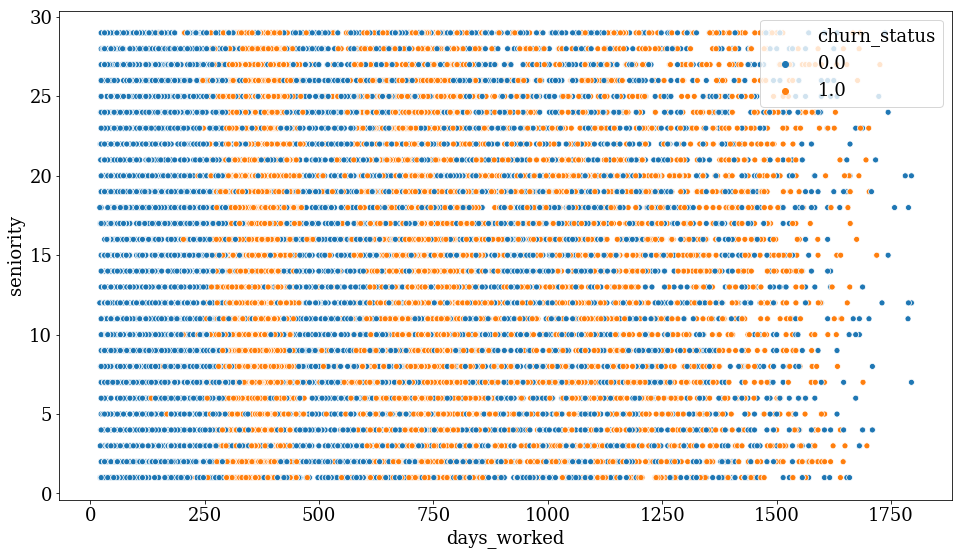

In [24]:
plt.figure(figsize = (16, 9))
sns.scatterplot(
    x = 'days_worked',
    y = 'seniority',
    data = data,
    hue = 'churn_status'
)

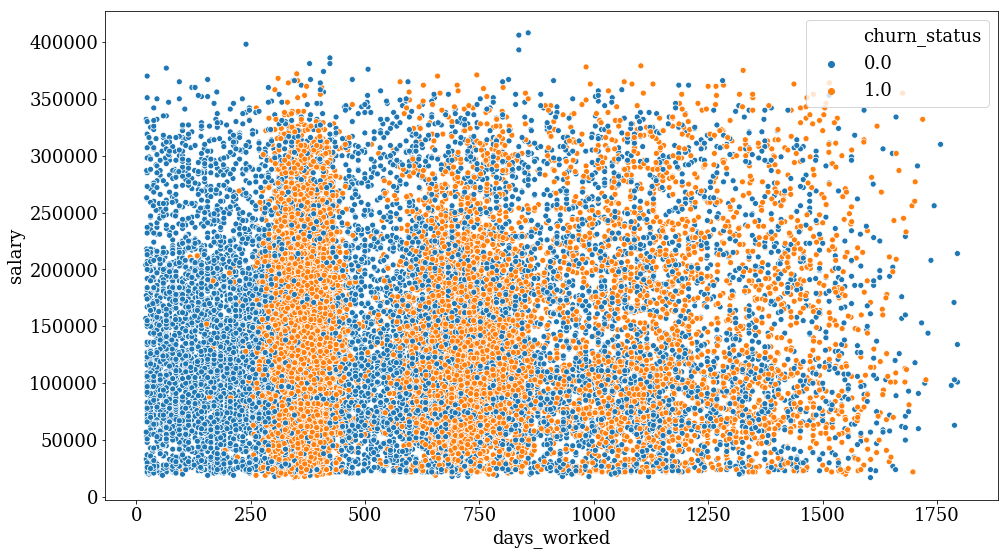

In [25]:
plt.figure(figsize = (16, 9))
sns.scatterplot(
    x = 'days_worked',
    y = 'salary',
    data = data,
    hue = 'churn_status'
)

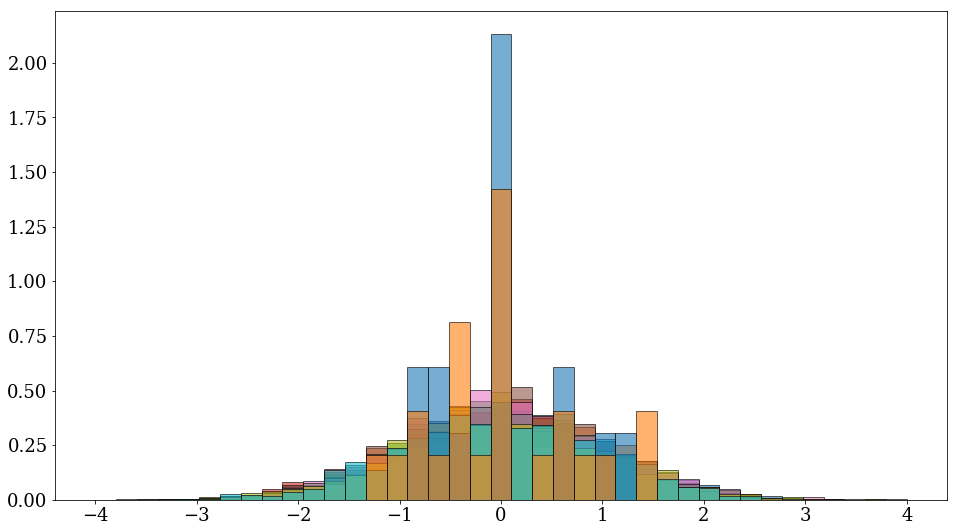

In [26]:
plt.figure(figsize = (16, 9))

for company_id in data['company_id'].unique():
    company_data = data.query('company_id == {}'.format(company_id))
    plt.hist(
        company_data['internal_salary_zscore'],
        bins = np.linspace(-4, 4, 40),
        edgecolor = 'k',
        alpha = 0.6,
        density = True
    );

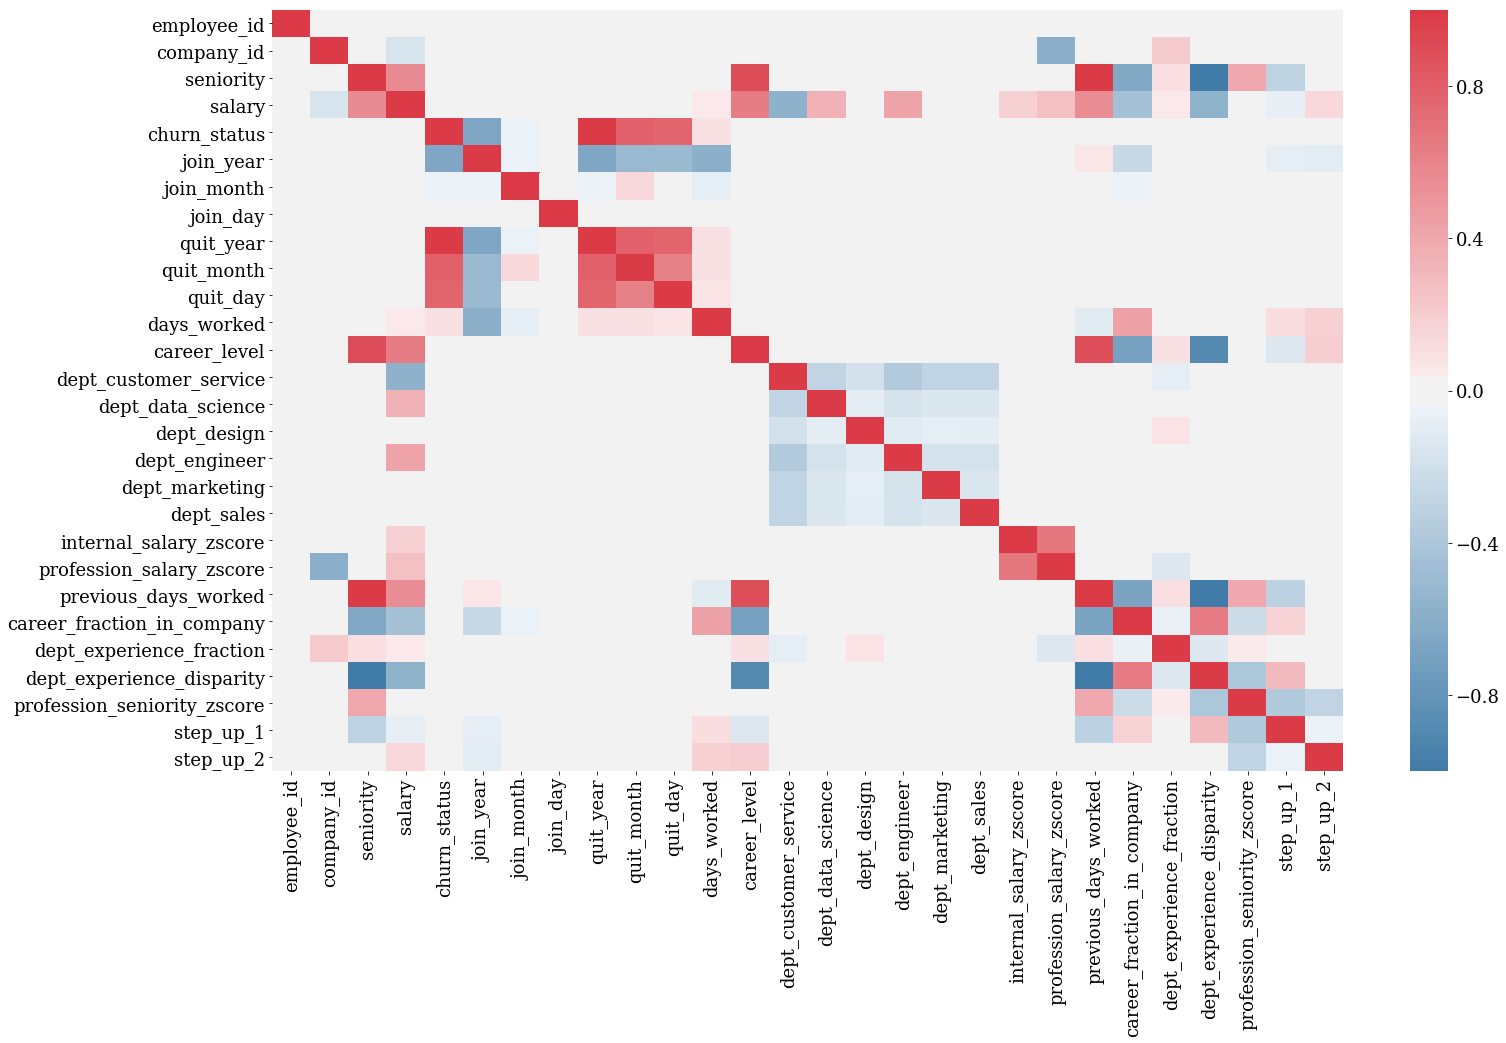

In [27]:
plt.figure(figsize = (24, 14))
sns.heatmap(data.corr(), cmap = sns.diverging_palette(240, 10, n = 256))

## 5. Modeling
In this section predictions are made for employee attrition based on the cleaned data that has features added to it.  First, I am going to define which features to take into account.  I'm leaving out things like the start and end date of employment, as that information has been transfered into the `days_worked` variable and I don't think it would be meaningful to include start days, months, and years.

In [28]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

In [29]:
target = 'churn_status'
features = ['career_level', 'company_id', 'days_worked',
           'dept_customer_service', 'dept_data_science', 'dept_design', 
            'dept_engineer', 'dept_marketing', 'dept_sales', 
            'salary', 'seniority', 'internal_salary_zscore',
           'profession_salary_zscore', 'dept_experience_fraction', 'previous_days_worked',
           'career_fraction_in_company', 'profession_seniority_zscore',
           'dept_experience_disparity', 'step_up_1', 'step_up_2']

In [30]:
for feat in features:
    if feat not in data.columns:
        raise ValueError('There is no feature {}.'.format(feat))

Now we're going to do something important and define the metrics that we want to track.  Based on these we can take a decision on what action to recommend.

In [31]:
from sklearn.metrics import confusion_matrix

In [32]:
def business_metric(y_pred, y_true, 
                    cost_of_loss = 100000, 
                    cost_of_intervention = 10000, 
                    probability_of_success = 0.2):
    ''' Important business metric. This would be fleshed out with someone who knows better. '''
    
    confusion_mat = confusion_matrix(y_true, y_pred)
    
    true_negatives = confusion_mat[0,0]
    false_negatives = confusion_mat[1,0]
    false_positives = confusion_mat[0,1]
    true_positives = confusion_mat[1,1]
    
    # We predicted that the person will quit 
    # but actually they will not. We incur the 
    # cost of the intervention.
    cost = false_positives * cost_of_intervention
    
    # We predict that the employee will not quit
    # but they are going to quit.  We incur the full
    # cost of loss.
    cost += false_negatives * cost_of_loss
    
    # We predict they will quit, and they actually will
    # but by doing our intervention we save N * probability_of_success 
    # of them and only incur the intervention cost for them.
    cost += true_positives * (cost_of_intervention + (1 - probability_of_success) * cost_of_loss)
    
    # True negatives are free so do nothing for them.
    
    return float(cost / len(y_true))

In [33]:
metrics = {
    'accuracy' : accuracy_score,
    'precision' : precision_score,
    'recall' : recall_score,
    'f1_score' : f1_score,
    'business_metric' : business_metric
}

We know from visual exploration of the data that the number of days worked is important and that employee attrition spikes around the one and two year employment times. Let's build a simple model that just guesses employees are going to quit if they're inside of a time window `quit_window` from one or two years of employment.

In [34]:
class NaiveBaselineModel(object):
    '''
    NaiveBaselineModel - Guess that any employee close
    to 1 or 2 years of employment is likely to quit.
    
    '''
    def __init__(self, quit_window = 60):
        self.quit_window = quit_window 
        
    def fit(x_train, y_train):
        pass
    
    def predict(self, days_worked):
        predictions = np.zeros(len(days_worked))
        predictions[np.where((days_worked > (365 - self.quit_window)) & (days_worked < (365 + self.quit_window)))] = 1.0
        predictions[np.where((days_worked > (2 * 365 - self.quit_window)) & (days_worked < (2 * 365 + self.quit_window)))] = 1.0
        return predictions 

    def predict_proba(self, days_worked):
        return self.predict(days_worked)

Let's also write a function useful for training our models.

In [35]:
def train_evaluate(model, x_train, x_test, y_train, y_test, metrics = {}, return_model = False):
    model.fit(x_train, y_train)

    y_pred_test = model.predict(x_test)
    y_pred_train = model.predict(x_train)
    
    results = {}
    for metric_name in metrics.keys():
        results[metric_name + '_test'] = metrics[metric_name](y_pred_test, y_test)
        results[metric_name + '_train'] = metrics[metric_name](y_pred_train, y_train)
    
    if return_model:
        return model, results
    else:
        return results

In [36]:
baseline_model = NaiveBaselineModel(60)
y_pred_baseline = baseline_model.predict(data['days_worked'].values)

print(accuracy_score(data['churn_status'].values, y_pred_baseline))
print(precision_score(data['churn_status'].values, y_pred_baseline))
print(recall_score(data['churn_status'].values, y_pred_baseline))

0.7002834008097166
0.7865928081870247
0.6202250518211431


Standardization of the features.

In [37]:
transformer = StandardScaler()
x = transformer.fit_transform(data[features].values)
y = data[target].values

x_train, x_test, y_train, y_test = train_test_split(x, y)

In [38]:
default_models = {
    'Logistic Regression' : LogisticRegression(),
    'Naive Bayes' : GaussianNB(),
    'Random Forest' : RandomForestClassifier(),
    'Gradient Boosted Trees' : GradientBoostingClassifier()
}

In [39]:
default_metrics = {}
for model in default_models.keys():
    default_metrics[model] = train_evaluate(
        model = default_models[model],
        x_train = x_train, 
        x_test = x_test, 
        y_train = y_train, 
        y_test = y_test,
        metrics = metrics
    )

In [40]:
for key, value in default_metrics.items():
    print(key)
    
    for k, v in value.items():
        print('\t', k, v)

Logistic Regression
	 accuracy_test 0.6050202429149798
	 accuracy_train 0.6087989203778678
	 precision_test 0.8733912002394493
	 precision_train 0.8628897413199568
	 recall_test 0.5914065666801783
	 recall_train 0.5998222343771366
	 f1_score_test 0.7052567975830815
	 f1_score_train 0.7076997539628119
	 business_metric_test 52644.534412955465
	 business_metric_train 53306.34278002699
Naive Bayes
	 accuracy_test 0.5815384615384616
	 accuracy_train 0.5833198380566802
	 precision_test 0.7390002993115834
	 precision_train 0.7347300088521688
	 recall_test 0.5905285816790241
	 recall_train 0.5979827089337176
	 f1_score_test 0.6564743419303377
	 f1_score_train 0.6593406593406593
	 business_metric_test 52879.35222672065
	 business_metric_train 53561.133603238864
Random Forest
	 accuracy_test 0.6981376518218624
	 accuracy_train 0.9861808367071525
	 precision_test 0.7117629452259803
	 precision_train 0.9832792367463362
	 recall_test 0.7252211039951204
	 recall_train 0.99147079242289
	 f1_score_te

It seems like the gradient boosted tree is working best for this dataset (without any tuning).  Let's write a function to do k-fold cross validation and tune the parameters.

In [41]:
from sklearn.model_selection import KFold, StratifiedKFold

In [42]:
def train_evaluate_kfold(model_builder, x, y, 
                         metrics = {}, k = 5, stratify = False, model_params = {}):
    ''' Train k-fold cross validation and return results
        in a DateFrame. '''
    
    if stratify:
        kf = StratifiedKFold(k, y)
    else:
        kf = KFold(k)
        
    results = {}
    
    for name in metrics.keys():
        results[name + '_test'] = np.zeros(k)
        results[name + '_train'] = np.zeros(k)
    
    fold_idx = 0
    for train_idx, test_idx in kf.split(x, y):
        model = model_builder(**model_params)
        
        
        current_result = train_evaluate(
            model = model, 
            x_train = x[train_idx],
            x_test = x[test_idx],
            y_train = y[train_idx],
            y_test = y[test_idx],
            metrics = metrics
        )
        
        for res in current_result.keys():
            results[res][fold_idx] = current_result[res]
        
        fold_idx += 1
        
    return pd.DataFrame(results)

In [43]:
kfold_results = train_evaluate_kfold(
    model_builder = GradientBoostingClassifier,
    x = x, 
    y = y,
    k = 5,
    metrics = metrics, 
    stratify = False,
    model_params = dict()
)

In [44]:
kfold_results.head(5)

,accuracy_test,accuracy_train,precision_test,precision_train,recall_test,recall_train,f1_score_test,f1_score_train,business_metric_test,business_metric_train
0,0.770445,0.771964,0.885192,0.893159,0.746992,0.741466,0.810241,0.810274,52123.481781,51347.672065
1,0.769028,0.771913,0.919428,0.914854,0.724844,0.734809,0.810622,0.815006,50698.380567,51707.995951
2,0.753239,0.772368,0.879735,0.897674,0.728380,0.740500,0.796935,0.811547,52004.048583,51416.497976
3,0.758907,0.775506,0.879955,0.897965,0.727528,0.745546,0.796515,0.814688,50672.064777,51703.947368
4,0.758704,0.773988,0.899236,0.904359,0.729849,0.738969,0.805737,0.813341,52495.951417,51263.663968


Now that training is easy, let's tune the hyperparameters of the model using this cross validation function.

In [45]:
parameter_limits = {
    'n_estimators' : [20, 400],
    'max_depth' : [2, 5]
}

parameter_values = {
    'loss' : ['deviance', 'exponential'] 
}

parameter_generators = {
    'n_estimators' : lambda x: np.random.randint(parameter_limits['n_estimators'][0], parameter_limits['n_estimators'][1], x),
    'max_depth' : lambda x: np.random.randint(parameter_limits['max_depth'][0], parameter_limits['max_depth'][1], x),
    'loss' : lambda x: np.random.choice(parameter_values['loss'], x)
}

In [46]:
from tqdm import tqdm

In [47]:
def stack_dicts(dictionaries):
    ''' Assuming same keys for all dictionaries, stack them into one with lists of values. '''
    
    keys = dictionaries[0].keys()
    
    output_dict = {}
    for key in keys:
        output_dict[key] = [dictionaries[i][key] for i in range(len(dictionaries))]
        
    return output_dict

def tune_hyperparameters(model_builder, n_iter, parameter_generators,
                         x, y, metrics = {}, k = 5, stratify = False):
    ''' Use random search to find the metric values for different parameter sets. '''
    
    # Get some parameters to test 
    parameters = {}
    for parameter in parameter_generators.keys():
        parameters[parameter] = parameter_generators[parameter](n_iter)
        
    # Summary of results    
    summary = []
    
    # Test them
    for iteration in tqdm(range(n_iter)):
                
        # Build current iteration
        current_parameters = {}
        for parameter in parameters.keys():
            current_parameters[parameter] = parameters[parameter][iteration]
        
        # Find results 
        current_results = train_evaluate_kfold(
            model_builder = GradientBoostingClassifier,
            x = x, 
            y = y,
            k = 5,
            metrics = metrics, 
            stratify = False,
            model_params = current_parameters
        )
        
        # Add scores by averaging folds 
        current_parameters.update(current_results.mean().to_dict())
        summary.append(current_parameters)
    
    return pd.DataFrame(stack_dicts(summary))

In [48]:
hyperparams_results = tune_hyperparameters(
    model_builder = GradientBoostingClassifier,
    n_iter = 100,
    x = x, 
    y = y,
    k = 4,
    metrics = metrics, 
    stratify = False,
    parameter_generators = parameter_generators
)

100%|██████████| 100/100 [40:41<00:00, 21.41s/it] 


In [49]:
hyperparams_results.sort_values('recall_test', ascending = False)

,n_estimators,max_depth,loss,accuracy_test,accuracy_train,precision_test,precision_train,recall_test,recall_train,f1_score_test,f1_score_train,business_metric_test,business_metric_train
10,338,4,deviance,0.833077,0.884676,0.888468,0.931629,0.821186,0.867366,0.853390,0.898339,50888.663968,50372.672065
30,320,4,deviance,0.829352,0.879089,0.887558,0.929040,0.816511,0.860932,0.850457,0.893677,50925.910931,50428.542510
73,304,4,deviance,0.826356,0.874281,0.886526,0.926390,0.813021,0.855697,0.848082,0.889628,50955.870445,50476.619433
67,374,4,exponential,0.822874,0.873704,0.886613,0.927564,0.808167,0.854081,0.845469,0.889296,50990.688259,50482.388664
82,240,4,deviance,0.817206,0.858016,0.887880,0.922246,0.800008,0.835322,0.841557,0.876620,51047.368421,50639.271255
36,386,3,deviance,0.814453,0.845466,0.885276,0.910736,0.797768,0.824950,0.839128,0.865690,51074.898785,50764.777328
59,312,4,exponential,0.813684,0.858988,0.885518,0.921974,0.796602,0.836825,0.838585,0.877323,51082.591093,50629.554656
54,230,4,deviance,0.814251,0.853836,0.887728,0.922338,0.796199,0.829500,0.839389,0.873451,51076.923077,50681.072874
88,311,4,exponential,0.811538,0.858654,0.884132,0.922420,0.794533,0.836087,0.836814,0.877121,51104.048583,50632.894737
12,287,4,exponential,0.808381,0.852368,0.883244,0.919699,0.790826,0.829054,0.834402,0.872022,51135.627530,50695.748988


Since running these random trials takes time, let's try to be smart and save them to a folder so that we don't lose them and we can gradually increase the number.

In [50]:
import glob, os

def check_and_create_directory(path):
    if not os.path.exists(path):
        os.mkdir(path)

In [51]:
random_samples_path = './samples'

# Low chance of repeat
sample_filename = '{}/{}.csv'.format(random_samples_path, np.random.randint(0, 1e9))
print('Saving samples to {}'.format(sample_filename))

check_and_create_directory(random_samples_path)
hyperparams_results.to_csv(sample_filename, index = False)

Saving samples to ./samples/339227563.csv


In [52]:
previous_results = []

for f in glob.glob(random_samples_path + '/*.csv'):
    previous_results.append(pd.read_csv(f))

if len(previous_results) > 0:
    samples = pd.concat(previous_results)
else:
    samples = hyperparams_results

In [53]:
samples.sort_values('recall_test', ascending = False)

,n_estimators,max_depth,loss,accuracy_test,accuracy_train,precision_test,precision_train,recall_test,recall_train,f1_score_test,f1_score_train,business_metric_test,business_metric_train
23,393,4,deviance,0.837126,0.893745,0.888646,0.935392,0.826721,0.878257,0.856460,0.905915,50848.178138,50281.983806
82,347,4,deviance,0.835506,0.887186,0.891029,0.934367,0.822956,0.869183,0.855564,0.900591,50864.372470,50347.570850
40,342,4,deviance,0.834656,0.886265,0.890737,0.934255,0.821950,0.867903,0.854890,0.899851,50872.874494,50356.781377
10,338,4,deviance,0.833077,0.884676,0.888468,0.931629,0.821186,0.867366,0.853390,0.898339,50888.663968,50372.672065
28,346,4,deviance,0.832348,0.885294,0.888041,0.932078,0.820346,0.867963,0.852766,0.898869,50895.951417,50366.497976
55,345,4,deviance,0.831619,0.884676,0.887452,0.931911,0.819707,0.867164,0.852142,0.898363,50903.238866,50372.672065
15,339,4,deviance,0.832389,0.884393,0.889934,0.933254,0.819317,0.865826,0.853100,0.898269,50895.546559,50375.506073
19,331,4,deviance,0.830607,0.881599,0.888494,0.931024,0.817676,0.863246,0.851536,0.895847,50913.360324,50403.441296
30,320,4,deviance,0.829352,0.879089,0.887558,0.929040,0.816511,0.860932,0.850457,0.893677,50925.910931,50428.542510
26,314,4,deviance,0.827571,0.877176,0.888279,0.929336,0.813637,0.857932,0.849245,0.892198,50943.724696,50447.672065


Let's now take a look at the parameter set which has the highest recall and use that to train our final model.

In [54]:
best_parameters = {
    'loss' : 'deviance',
    'n_estimators' : 360,
    'max_depth' : 4
}

In [55]:
model, results = train_evaluate(
    model = GradientBoostingClassifier(**best_parameters),
    x_train = x_train,
    x_test = x_test,
    y_train = y_train,
    y_test = y_test,
    metrics = metrics,
    return_model = True
)

In [56]:
results

{'accuracy_test': 0.8241295546558705,
 'accuracy_train': 0.8907422402159244,
 'precision_test': 0.8790781203232565,
 'precision_train': 0.9355758827579423,
 'recall_test': 0.8115501519756839,
 'recall_train': 0.8741843580553258,
 'f1_score_test': 0.8439655172413792,
 'f1_score_train': 0.9038388445458,
 'business_metric_test': 50453.44129554656,
 'business_metric_train': 50486.909581646425}

Text(0.5, 0, 'Importance')

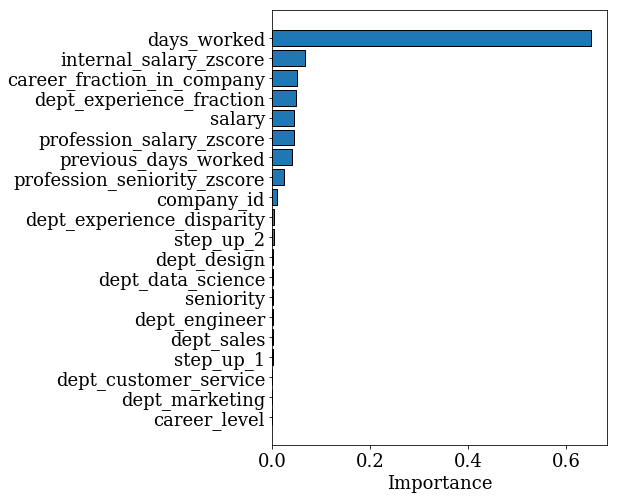

In [57]:
idx = np.argsort(model.feature_importances_)

plt.figure(figsize = (6, 8))
plt.barh(
    [features[i] for i in idx],
    [model.feature_importances_[i] for i in idx],
    edgecolor = 'k'
)
plt.xlabel('Importance')

# 6. Interpretation of Model
The model trainined above heavily relies on knowing how many days an employee has worked so far.  The trend is clearly evident from the visual exploration; people quit around one and two years on the job.  Our simple baseline model took advantage of this fact as well.  The second most important factor in attrition appears to be the relative salary gap between peers working in the same division.

### 6.1 Recommended Actions
* Track employees and focus on those around the one and two year mark, the model can predict those at risk employees for you.
* Offer these employees a raise that brings their salary closer to the mean for their division and career level.  The degree to which this raise can be offered without affecting the bottom line depends on how much you expect to lose by replacing this candidate with a less experienced one (hard to quantify).
* Start tracking job satisfaction and hours worked per week.  Stronger predictions could be made if the company collected job satisfaction surveys and tracked the hours each employee is working on per week.
* The business metric defined is probably not perfect but it follows the recall, so maximizing recall seems sensible.

In [58]:
np.sum(data['churn_status'].values) * 100000 / len(data)

54704.45344129555

The number above is the cost (per employee) of replacing all those employees who quit if we offer no incentives.  When compared with our best business metric (cost per employee) we see that we can save 4,000 - 5,000 per employee.